In [1]:
from matplotlib import pyplot as plt
import pandas as pd

df = pd.concat((
    pd.read_csv('./out/replay_results.csv', index_col=[0, 1]),
    pd.read_csv('./out/replay_results_baseline.csv', index_col=[0, 1]),
))

df

reward     reward.1     reward.2  \
                    createdAt                                           
MABTree ε-greedy MF 2024-10-02    41.290703    51.737500    58.120417   
                    2024-10-03    74.257347    84.721875    98.521091   
                    2024-10-04   105.431474   123.484097   132.264301   
                    2024-10-05   145.129127   161.269583   167.603807   
                    2024-10-06   177.534994   194.468472   210.332696   
...                                     ...          ...          ...   
LinUCB              2024-11-26  2231.950022  2170.541043  2317.622956   
                    2024-11-27  2283.140741  2215.580405  2367.188992   
                    2024-11-28  2336.289709  2262.306510  2420.386209   
                    2024-11-29  2379.558320  2307.977066  2471.465613   
                    2024-11-30  2421.079550  2353.974151  2515.327496   

                                   reward.3     reward.4  
                    createdAt                             
MABTree ε-greedy MF 2024-10-02    58.074365    63.758326  
                    2024-10-03    94.013254   105.997145  
                    2024-10-04   145.930139   148.709923  
                    2024-10-05   176.174236   179.872665  
                    2024-10-06   214.041181   224.321276  
...                                     ...          ...  
LinUCB              2024-11-26  2357.203523  2304.239133  
                    2024-11-27  2412.131561  2360.057008  
                    2024-11-28  2468.750671  2413.221051  
                    2024-11-29  2526.764423  2463.074385  
                    2024-11-30  2570.349423  2497.253256  

[420 rows x 5 columns]

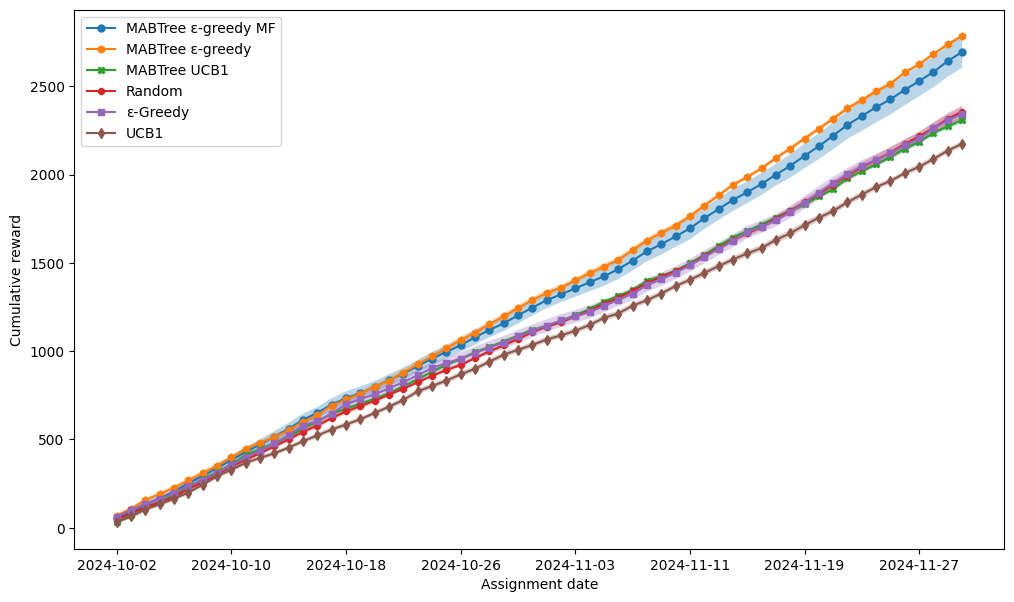

In [2]:
plt.figure(figsize=(12, 7))
plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))
for marker, (name, group) in zip(['o', 'h', 'X', '8', 's', 'd'], df.groupby(level=0, sort=False)):
    m = group.mean(axis=1)
    s = group.std(axis=1)

    CI_min = m - 1.96 * s / group.shape[1] ** 0.5
    CI_max = m + 1.96 * s / group.shape[1] ** 0.5

    plt.plot(group.index.get_level_values(1), m, label=name, marker=marker, markersize=5)
    plt.fill_between(group.index.get_level_values(1), CI_min, CI_max, alpha=0.3)

#plt.title('Cumulative reward from 2024-10-01 to 2024-11-30')
plt.ylabel('Cumulative reward')
plt.xlabel('Assignment date')
plt.legend()
plt.savefig('./out/cumulative_reward.pdf', format='pdf', bbox_inches='tight')
plt.show()

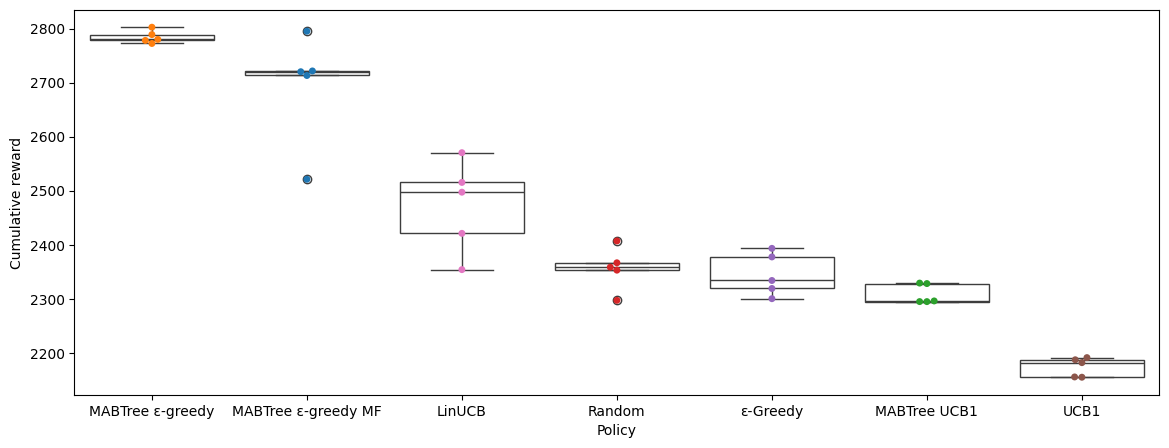

In [4]:
import seaborn as sns
lasted = df.groupby(level=0, sort=False).last().T
rank = lasted.median().sort_values(ascending=False).index

plt.figure(figsize=(14, 5))
sns.boxplot(data=lasted, color='white', order=rank)
sns.swarmplot(data=lasted)
#plt.title('Cumulated reward distribution at 2024-11-30')
plt.ylabel('Cumulative reward')
plt.xlabel('Policy')
plt.savefig('./out/cumulative_reward_2.pdf', format='pdf')
plt.show()

In [6]:
def highlight_max(s):
    d = s.sort_values(ascending=False)

    style = {
        d.index[0]: 'textbf:--rwrap ;',   # max
        d.index[1]: 'underline:--rwrap ;',  # second max
        d.index[-1]: 'textit:--rwrap ;',  # min
    }
    return [style.get(v, '') for v in s.index]


styled = lasted.reset_index(drop=True).T.assign(
    mean=lasted.mean(axis=0),
    std=lasted.std(axis=0),
).style.apply(highlight_max, axis=0).format('{:.3f}')

styled.format_index(escape='latex').to_latex(
    './out/cumulative_reward_table.tex',
    hrules=True,
    caption='Cumulated reward at 2024-11-30')

styled

,0,1,2,3,4,mean,std
MABTree ε-greedy MF,2521.180,2713.153,2721.568,2795.078,2720.121,2694.220,102.338
MABTree ε-greedy,2778.067,2772.415,2779.959,2802.475,2788.883,2784.360,11.729
MABTree UCB1,2294.839,2329.075,2296.042,2328.182,2294.792,2308.586,18.306
Random,2407.044,2353.016,2366.591,2358.493,2297.166,2356.462,39.348
ε-Greedy,2300.234,2333.870,2319.098,2377.456,2393.329,2344.797,39.331
UCB1,2181.883,2191.169,2154.899,2187.171,2155.401,2174.105,17.615
LinUCB,2421.080,2353.974,2515.327,2570.349,2497.253,2471.597,84.720
